In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from nelpy.analysis import replay
import random
from matplotlib.ticker import AutoMinorLocator
from scipy import stats


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## load replay dataframe

In [3]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay"

df = replay_run.load_results(save_path, pre_task_post=True)


## run main analysis to find event bias

In [9]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_layer_bias"

batch_analysis.run(
    df,
    save_path,
    influence_of_layer_bias_on_replay.run,
    parallel=True,
    overwrite=False,
    replay_df=df,
)
# load results
df = influence_of_layer_bias_on_replay.load_results(save_path)


100%|██████████| 64/64 [00:00<00:00, 339.92it/s]


## test plot of inverse num of samples weighted avg

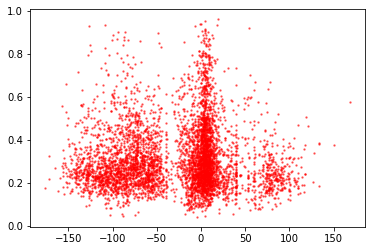

In [14]:
plt.scatter(df.ins, df.trajectory_score,color='r',alpha=0.5,s=2)


## compare different weighted avg

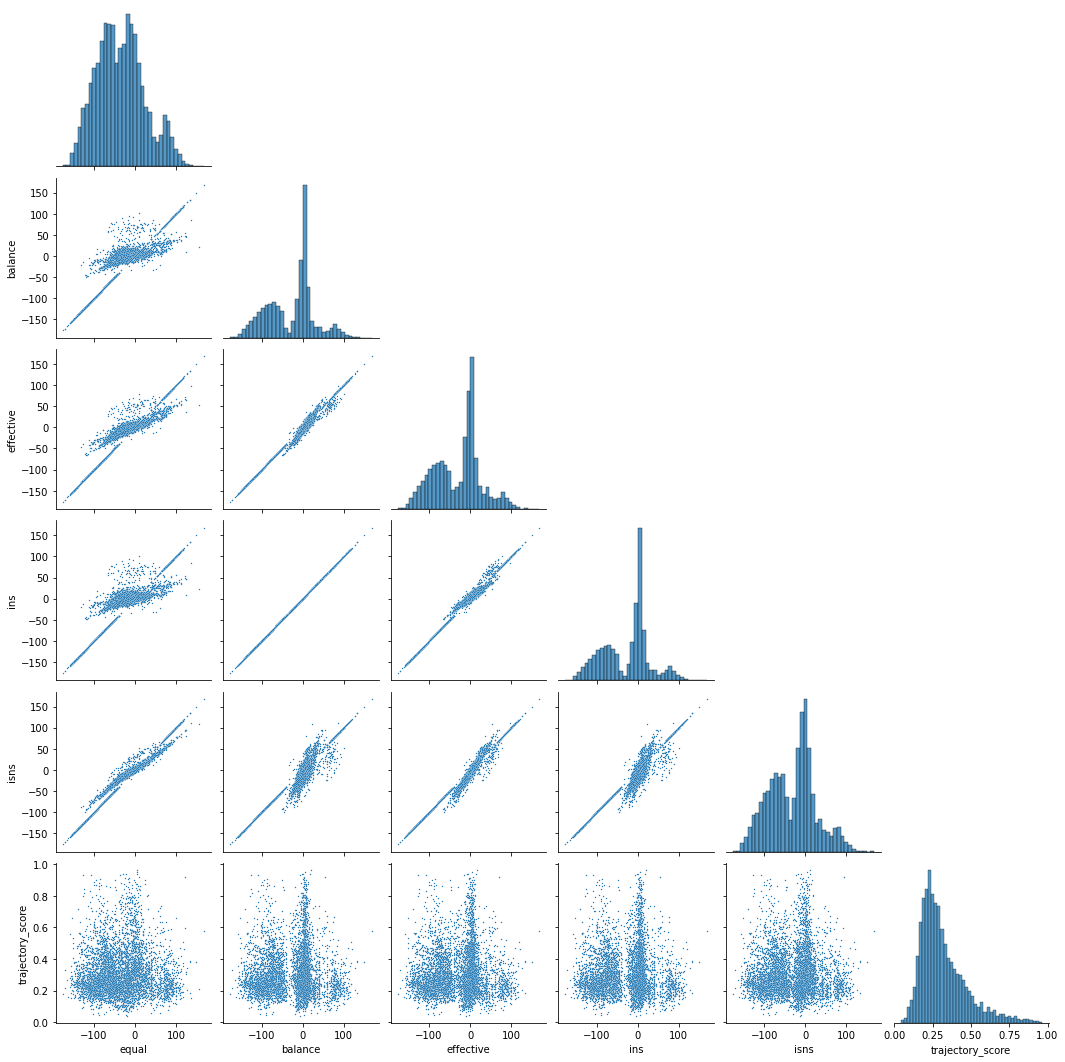

In [17]:
sns.pairplot(df, corner=True,vars=['equal','balance', 'effective', 'ins', 'isns','trajectory_score'],plot_kws={'s':2})


## kmeans on avg distance and trajectory score

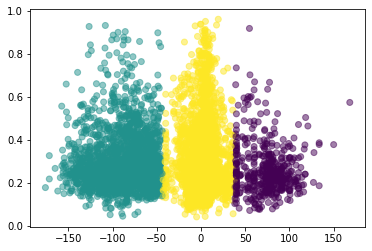

In [61]:
def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

X = df[['ins','trajectory_score']].values

labels, centroids, X_hat = kmeans_missing(X, 3)
df['kmeans_labels'] = labels

plt.scatter(X[:, 0], X[:, 1], c=labels.astype(float),alpha=.5)

### assign cluster labels to deep/sup/mixed

In [71]:
mean_dist_cluster = [df['ins'][labels==0].mean(), df['ins'][labels==1].mean(), df['ins'][labels==2].mean()]

deepSuperficial = ['deep','mixed','sup']
sort_idx = np.argsort(mean_dist_cluster)
for i,sort_i in enumerate(sort_idx):
    df.loc[df.kmeans_labels==sort_i,'kmeans_labels'] = deepSuperficial[i]

## look at traj score of deep / sup / mixed clusters

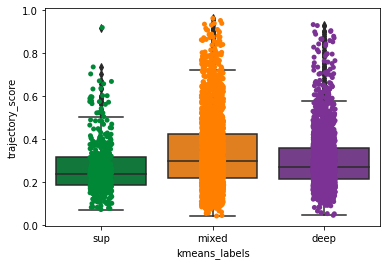

<AxesSubplot:xlabel='trajectory_score', ylabel='Proportion'>

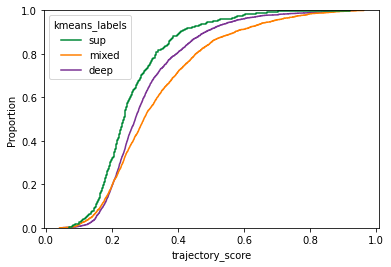

In [83]:
group_colors = {"sup": "#008837",  "mixed": "#ff7f00", "deep": "#7b3294"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(x="kmeans_labels", y="trajectory_score", data=df)
sns.stripplot(x="kmeans_labels", y="trajectory_score", data=df, linewidth=0,dodge=True)
plt.show()
sns.ecdfplot(data=df, x="trajectory_score", hue="kmeans_labels",hue_order=group_colors.keys())


## look at trajectory score of sig events

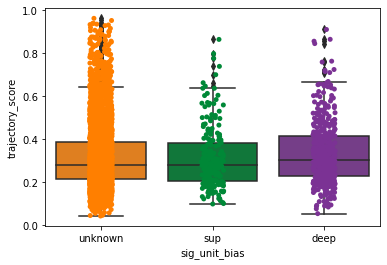

<AxesSubplot:xlabel='trajectory_score', ylabel='Proportion'>

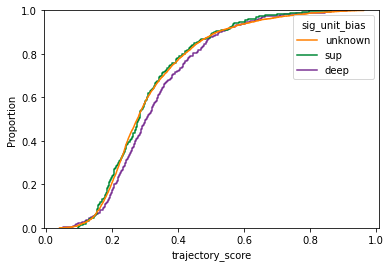

In [85]:
group_colors = { "mixed": "#ff7f00", "sup": "#008837", "deep": "#7b3294"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(x="sig_unit_bias", y="trajectory_score", data=df)
sns.stripplot(x="sig_unit_bias", y="trajectory_score", data=df, linewidth=0)
plt.show()
sns.ecdfplot(data=df, x="trajectory_score", hue="sig_unit_bias")


In [161]:
df.basepath.unique()

basepath = "Z:\\Data\\GrosmarkAD\\Achilles\\Achilles_11012013"

start = df[(df.score_pval_time_swap < 0.05) & (df.basepath == basepath)].start
stop = df[(df.score_pval_time_swap < 0.05) & (df.basepath == basepath)].stop
replay_epochs = nel.EpochArray(np.array([start, stop]).T)
replay_epochs = replay_epochs.expand(0.05)

start = df[(df.basepath == basepath)].start
stop = df[(df.basepath == basepath)].stop
replay_canidates = nel.EpochArray(np.array([start, stop]).T)
replay_canidates = replay_canidates.expand(0.05)

st, cell_metrics = loading.load_spikes(
    basepath, brainRegion="CA1", putativeCellType="Pyr"
)
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)


In [162]:
st, replay_epochs, replay_canidates


(<SpikeTrainArray at 0x2c31882a250: 94 units> at 20000 Hz,
 <EpochArray at 0x2c31a203520: 273 epochs> of length 52.6464 seconds,
 <EpochArray at 0x2c31a203190: 3,971 epochs> of length 6:25:936 minutes)

In [163]:
replay_par_mat = functions.get_participation(
    st.data, replay_epochs.starts, replay_epochs.stops, par_type="binary"
)
non_replay_par_mat = functions.get_participation(
    st.data, replay_canidates.starts, replay_canidates.stops, par_type="binary"
)


<AxesSubplot:>

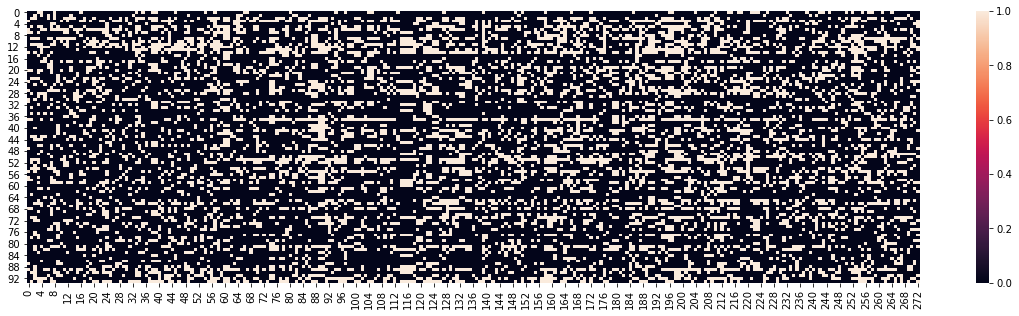

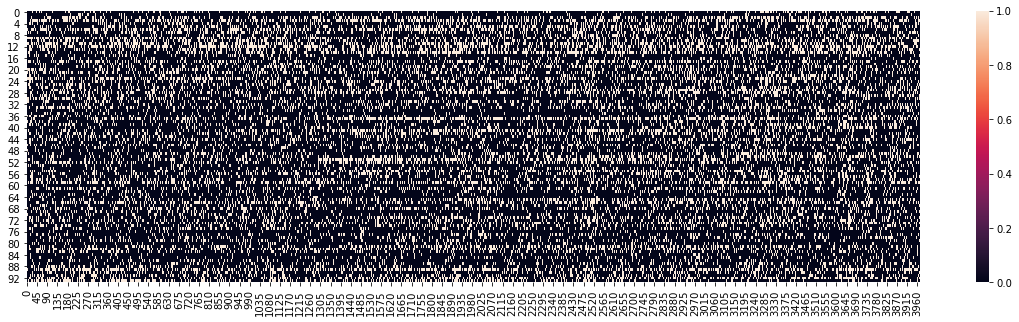

In [164]:
plt.figure(figsize=(20, 5))
sns.heatmap(replay_par_mat)

plt.figure(figsize=(20, 5))
sns.heatmap(non_replay_par_mat)


In [322]:
def shuffle_labels(labels):
    """
    Shuffle labels
    Input:
        labels: labels
    Output:
        shuffled_labels: shuffled labels
    """
    return np.random.permutation(labels).reshape(labels.shape)


def get_shuffled_labels(cell_metrics, replay_par_mat, ep, n_shuffles=1000):
    """
    Shuffle labels and get the number of deep and superficial cells
    Input:
        cell_metrics: cell metrics dataframe
        replay_par_mat: participation matrix
        ep: epoch number, current replay event
        n_shuffles: number of shuffles
    Output:
        n_deep: shuffled number of deep cells
        n_sup: shuffled number of superficial cells
    """
    n_deep = []
    n_sup = []
    for _ in range(n_shuffles):
        labels = shuffle_labels(cell_metrics.deepSuperficial)
        n_deep.append(sum(labels[replay_par_mat[:, ep] == 1] == "Deep"))
        n_sup.append(sum(labels[replay_par_mat[:, ep] == 1] == "Superficial"))
    return n_deep, n_sup


def get_significant_events(cell_metrics, replay_par_mat, n_shuffles=1000, q_perc=90):
    """
    Get the number of significant events
    Input:
        cell_metrics: cell metrics dataframe
        replay_par_mat: participation matrix
        n_shuffles: number of shuffles
        q_perc: percentile
    Output:
        sig_idx_deep: index of significant events in deep cells
        sig_idx_sup: index of significant events in superficial cells
    """
    # initialize variables
    n_deep = np.zeros([n_shuffles, replay_par_mat.shape[1]])
    n_sup = np.zeros([n_shuffles, replay_par_mat.shape[1]])

    # get the shuffled number of deep and superficial cells
    for i in range(replay_par_mat.shape[1]):
        n_deep[:, i], n_sup[:, i] = get_shuffled_labels(cell_metrics, replay_par_mat, i)

    # get the number of observed deep and superficial cells
    n_deep_obs = []
    n_sup_obs = []
    for i in range(replay_par_mat.shape[1]):
        cur_idx = replay_par_mat[:, i] == 1
        n_deep_obs.append(sum(cell_metrics[cur_idx].deepSuperficial == "Deep"))
        n_sup_obs.append(sum(cell_metrics[cur_idx].deepSuperficial == "Superficial"))

    # get the index of significant events
    sig_idx_deep, _ = functions.get_significant_events(
        np.hstack(n_deep_obs), n_deep, q=q_perc
    )
    sig_idx_sup, _ = functions.get_significant_events(
        np.hstack(n_sup_obs), n_sup, q=q_perc
    )

    return sig_idx_deep, sig_idx_sup


def run(basepath, df, n_shuffles=1000, q_perc=90):

    df_idx = (df.score_pval_time_swap < 0.05) & (df.basepath == basepath)
    # get the replay epochs for this basepath
    start = df[df_idx].start
    stop = df[df_idx].stop
    replay_epochs = nel.EpochArray(np.array([start, stop]).T)
    # expand the epochs by 50ms
    replay_epochs = replay_epochs.expand(0.05)
    # load the spikes
    st, cell_metrics = loading.load_spikes(
        basepath, brainRegion="CA1", putativeCellType="Pyr"
    )
    # add deep superficial labels
    cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)
    # get the participation matrix
    replay_par_mat = functions.get_participation(
        st.data, replay_epochs.starts, replay_epochs.stops, par_type="binary"
    )
    # get the significant events
    sig_idx_deep, sig_idx_sup = get_significant_events(
        cell_metrics, replay_par_mat, n_shuffles=n_shuffles, q_perc=q_perc
    )

    temp_df = df[df_idx]
    temp_df.reset_index(inplace=True)
    temp_df["sig_unit_bias"] = "unknown"
    temp_df.loc[sig_idx_sup, "sig_bias"] = "sup"
    temp_df.loc[sig_idx_deep, "sig_bias"] = "deep"

    return temp_df


temp_df = run(basepath, df)


ValueError: Must have equal len keys and value when setting with an iterable

In [319]:
sig_idx_deep, pval_deep = functions.get_significant_events(
    np.hstack(n_deep_obs), n_deep, q=90
)
sig_idx_sup, pval_sup = functions.get_significant_events(
    np.hstack(n_sup_obs), n_sup, q=90
)
sig_idx_sup, sig_idx_deep


(array([ 15,  25,  46,  47, 107, 124, 125, 244], dtype=int64),
 array([ 13,  16,  35, 217, 229], dtype=int64))

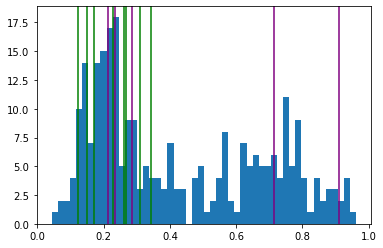

In [320]:
plt.hist(
    df[(df.score_pval_time_swap < 0.05) & (df.basepath == basepath)].trajectory_score,
    50,
)

trajectory_score = (
    df[(df.score_pval_time_swap < 0.05) & (df.basepath == basepath)]
    .iloc[sig_idx_sup]
    .trajectory_score
)
for t_score in trajectory_score:
    plt.axvline(t_score, color="g")

trajectory_score = (
    df[(df.score_pval_time_swap < 0.05) & (df.basepath == basepath)]
    .iloc[sig_idx_deep]
    .trajectory_score
)
for t_score in trajectory_score:
    plt.axvline(t_score, color="purple")


In [ ]:
def get_color_code(cell_metrics):
    colors1 = []
    for i in range(len(cell_metrics["deepSuperficial"])):
        if cell_metrics.deepSuperficial.iloc[i] == "Deep":
            # colors1.append('#7b3294')
            colors1.append("purple")
        elif cell_metrics.deepSuperficial.iloc[i] == "Superficial":
            # colors1.append('#008837')
            colors1.append("green")
        else:
            colors1.append("lightgrey")
    return colors1


def plot_raster_examples(st, replay_canidates, cell_metrics, events):

    if isinstance(events, int):
        n_panels = 1
    else:
        n_panels = len(events)

    fig, axs = plt.subplots(
        1,
        n_panels,
        figsize=functions.set_size(
            "thesis", fraction=n_panels / 2, subplots=(2, n_panels)
        ),
        edgecolor="k",
    )
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    axs = axs.ravel()

    for i, event in enumerate(events):
        rank_orders, rank_order_mat = functions.get_rank_order(
            st, replay_canidates[int(event)], method="peak_fr", padding=0
        )
        colors1 = get_color_code(cell_metrics)
        order_idx = np.argsort(rank_orders)

        axs[i].eventplot(
            st[replay_canidates[int(event)]].data[order_idx],
            colors=np.array(colors1)[order_idx],
            linelengths=1,
            linewidths=2,
        )
        # dir(st)
        axs[i].set_ylim(-1, st[replay_canidates[int(event)]].n_active + 1)
        sns.despine()


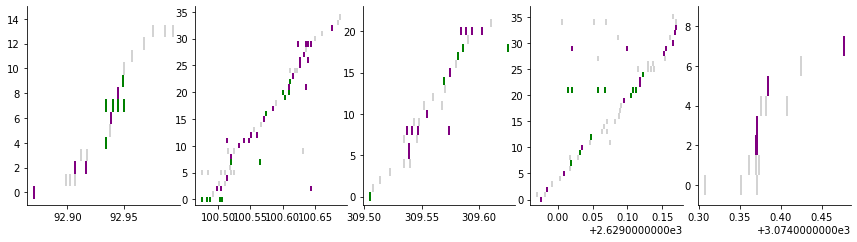

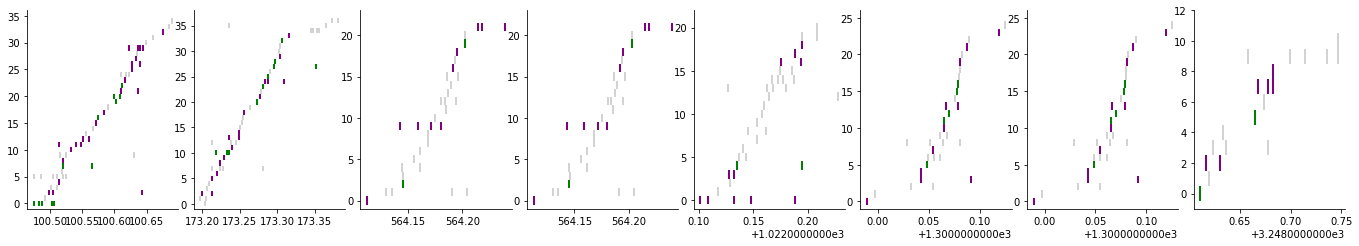

In [316]:
sig_idx_deep, pval_deep = functions.get_significant_events(
    np.hstack(n_deep_obs), n_deep, q=90
)
sig_idx_sup, pval_sup = functions.get_significant_events(
    np.hstack(n_sup_obs), n_sup, q=90
)
sig_idx_sup, sig_idx_deep

plot_raster_examples(st, replay_canidates, cell_metrics, sig_idx_deep)

plot_raster_examples(st, replay_canidates, cell_metrics, sig_idx_sup)


In [ ]:
prop_deep = []
prop_sup = []
rel_prop = []
for i in range(replay_par_mat.shape[1]):
    n_deep = sum(cell_metrics[replay_par_mat[:, i] == 1].deepSuperficial == "Deep")
    n_sup = sum(
        cell_metrics[replay_par_mat[:, i] == 1].deepSuperficial == "Superficial"
    )

    prop_deep.append(n_deep / cell_metrics.shape[0])
    prop_sup.append(n_sup / cell_metrics.shape[0])
    # catch divide by zero
    # if n_sup == 0:
    #     rel_prop.append(np.nan)
    # else:
    rel_prop.append((n_deep - n_sup))

prop_deep = np.array(prop_deep)
prop_sup = np.array(prop_sup)
rel_prop = np.array(rel_prop)

# rel_prop = stats.zscore(rel_prop)

plt.figure(figsize=(20, 5))
plt.plot(prop_deep, color="purple")
plt.plot(prop_sup, color="g")

plt.axhline(prop_deep.mean(), color="purple", linestyle="--")
plt.axhline(prop_sup.mean(), color="g", linestyle="--")

plt.axhline(
    cell_metrics.deepSuperficial.value_counts()["Deep"] / cell_metrics.shape[0],
    color="purple",
    linestyle="--",
)
plt.axhline(
    cell_metrics.deepSuperficial.value_counts()["Superficial"] / cell_metrics.shape[0],
    color="g",
    linestyle="--",
)

plt.figure(figsize=(20, 5))
plt.plot(np.array(prop_deep) - np.array(prop_sup), "-k")

plt.figure(figsize=(20, 5))
plt.plot(rel_prop, "-k")
plt.axhline(np.nanmean(rel_prop), color="orange", linestyle="--")
plt.axhline(-2, color="orange", linestyle="--")
plt.axhline(2, color="orange", linestyle="--")
